In [236]:
import numpy as np
import pandas as pd

from scipy.optimize import brentq
from scipy.stats import norm
from scipy.optimize import least_squares

import matplotlib.pyplot as plt

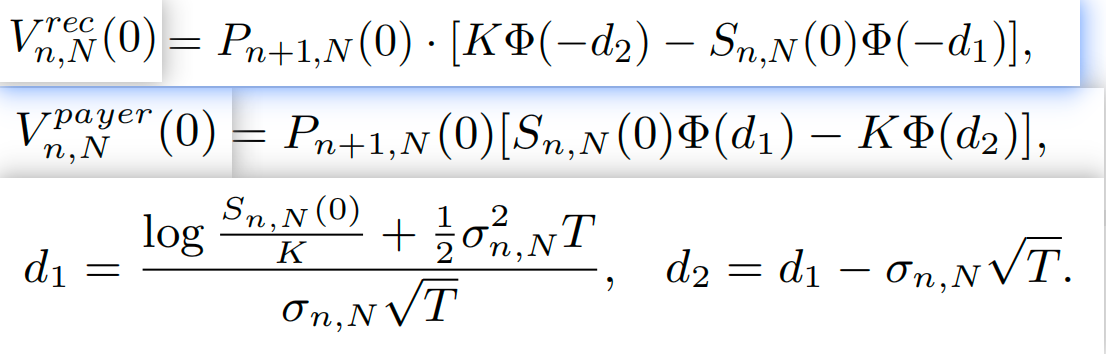

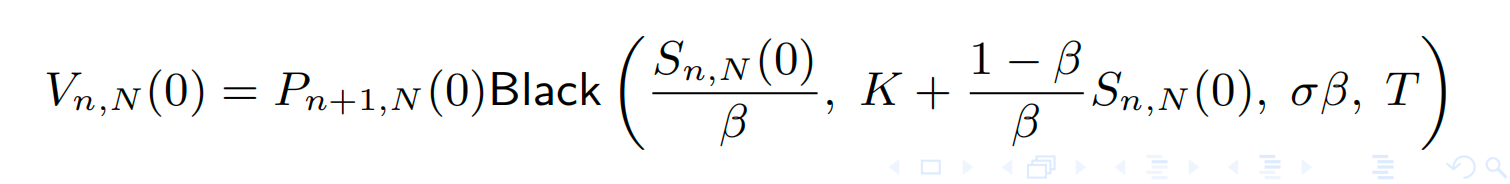

In [10]:
# def black76_Call(F, K, T, r, sigma):
#     discount_factor = np.exp(-r*T)
#     #F = S0*np.exp(r*T)
#     d1 = (np.log(F/K)+(1/2)*(sigma**2)*T)/(sigma*np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     price = discount_factor * ((F*norm.cdf(d1)) - (K*norm.cdf(d2)))
#     return price
# def black76_Put(F, K, T, r, sigma):
#     discount_factor = np.exp(-r*T)
#     #F = S0*np.exp(r*T)
#     d1 = (np.log(F/K)+1/2*(sigma**2)*T)/(sigma*np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     price = discount_factor * ((K*norm.cdf(-d2)) - (F*norm.cdf(-d1)))
#     return price

In [142]:
def cal_v_swaption_rec(S, PVBP, vol, K, T):
    d1 = (np.log(S/K) + 0.5*vol**2*T)/(vol*np.sqrt(T))
    d2 = d1-vol*np.sqrt(T)
    return PVBP*(K*norm.cdf(-d2) - S*norm.cdf(-d1))

def cal_v_swaption_payer(S, PVBP, vol, K, T):
    d1 = (np.log(S/K) + 0.5*vol**2*T)/(vol*np.sqrt(T))
    d2 = d1-vol*np.sqrt(T)
    return PVBP*(S*norm.cdf(d1) - K*norm.cdf(d2))

#OTM S < K
def ivol_payer(S, PVBP, price, K, T):
    try:
        return brentq(lambda vol: price - cal_v_swaption_payer(S, PVBP, vol, K, T), 1e-12, 1000.0)
    except Exception:
        return np.nan
#OTM S > K
def ivol_rec(S, PVBP, price, K, T):
    try:
        return brentq(lambda vol: price - cal_v_swaption_rec(S, PVBP, vol, K, T), 1e-12, 1000.0)
    except Exception:
        return np.nan

In [169]:
#payer-call receiver-put
def black76_Call(F, K, T, sigma):
    #discount_factor = np.exp(-r*T)
    #F = S0*np.exp(r*T)
    d1 = (np.log(F/K)+(1/2)*(sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = F*norm.cdf(d1) - K*norm.cdf(d2)
    return price
def black76_Put(F, K, T, sigma):
    #discount_factor = np.exp(-r*T)
    #F = S0*np.exp(r*T)
    d1 = (np.log(F/K)+1/2*(sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = K*norm.cdf(-d2) - F*norm.cdf(-d1)
    return price

def dd_payer(PVBP, S, K, vol, T, beta):
    return PVBP*black76_Call(S/beta, K + (1-beta)/beta*S, T, vol*beta)

def dd_rec( PVBP, S, K, vol, T, beta):
    return PVBP*black76_Put(S/beta, K + (1-beta)/beta*S, T, vol*beta)

In [196]:
def ddcalibration(beta, row):
    S = row.iloc[2]
    PVBP = row.iloc[3]
    T = row.iloc[0]
    
    err = 0
    vols = row.iloc[4:]
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    

    for i, bp_change in enumerate(bp_changes):
        #rec
        if bp_change < 0:
            K = S+bp_change
            # print(PVBP, S, K, vols.iloc[5], T, beta[0])
            price = dd_rec(PVBP, S, K, vols.iloc[5], T, beta[0])
            # print(price)
            # return
            err += (vols.iloc[i] - ivol_rec(S, PVBP, price, K, T))**2
        #payer
        else:
            K = S+bp_change
            price = dd_payer(PVBP, S, K, vols.iloc[5], T, beta[0])
            #print(price)
            err += (vols.iloc[i] - ivol_payer(S, PVBP, price, K, T))**2

    return err

In [136]:
def DD_fit_beta(row):
    guess = [0.7]
    bounds = (0,1)
    res = least_squares(lambda beta: ddcalibration(beta, row), guess, bounds=bounds)

    return res.x[0]

In [225]:
def dd_vol(row):
    beta = row.iloc[-1]
    S = row.iloc[2]
    K = S
    PVBP = row.iloc[3]
    T = row.iloc[0]
    ATMvol = row.iloc[9]
    
    price = dd_rec(PVBP, S, K, ATMvol, T, beta)
    return ivol_rec(S, PVBP, price, K, T)

In [229]:
def cal_dd_vol(row):
    beta = row.iloc[-2]
    S = row.iloc[2]
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    PVBP = row.iloc[3]
    T = row.iloc[0]
    dd_ATMvol = row.iloc[-1]

    dd_vols = []

    for i, bp_change in enumerate(bp_changes):
        #rec
        if bp_change < 0:
            K = S+bp_change
            # print(PVBP, S, K, vols.iloc[5], T, beta[0])
            price = dd_rec(PVBP, S, K, dd_ATMvol, T, beta)
            # print(price)
            # return
            dd_vols.append(ivol_rec(S, PVBP, price, K, T))
        #payer
        else:
            K = S+bp_change
            price = dd_payer(PVBP, S, K, dd_ATMvol, T, beta)
            #print(price)
            
            dd_vols.append(ivol_payer(S, PVBP, price, K, T))
    
    
    return dd_vols

In [226]:
ivol = pd.read_excel('IR Data.xlsx', sheet_name = 'Swaption', skiprows = 2)
ivol[ivol.columns[2:]] = ivol[ivol.columns[2:]]/100

fsr = pd.read_csv('fsr.csv')
fsr[ivol.columns[2:]] = ivol[ivol.columns[2:]]
beta = [DD_fit_beta(fsr.iloc[i]) for i in range(len(fsr))]
fsr['beta'] = beta

dd_vols = [dd_vol(fsr.iloc[i]) for i in range(len(fsr))]
fsr['vol'] = dd_vols

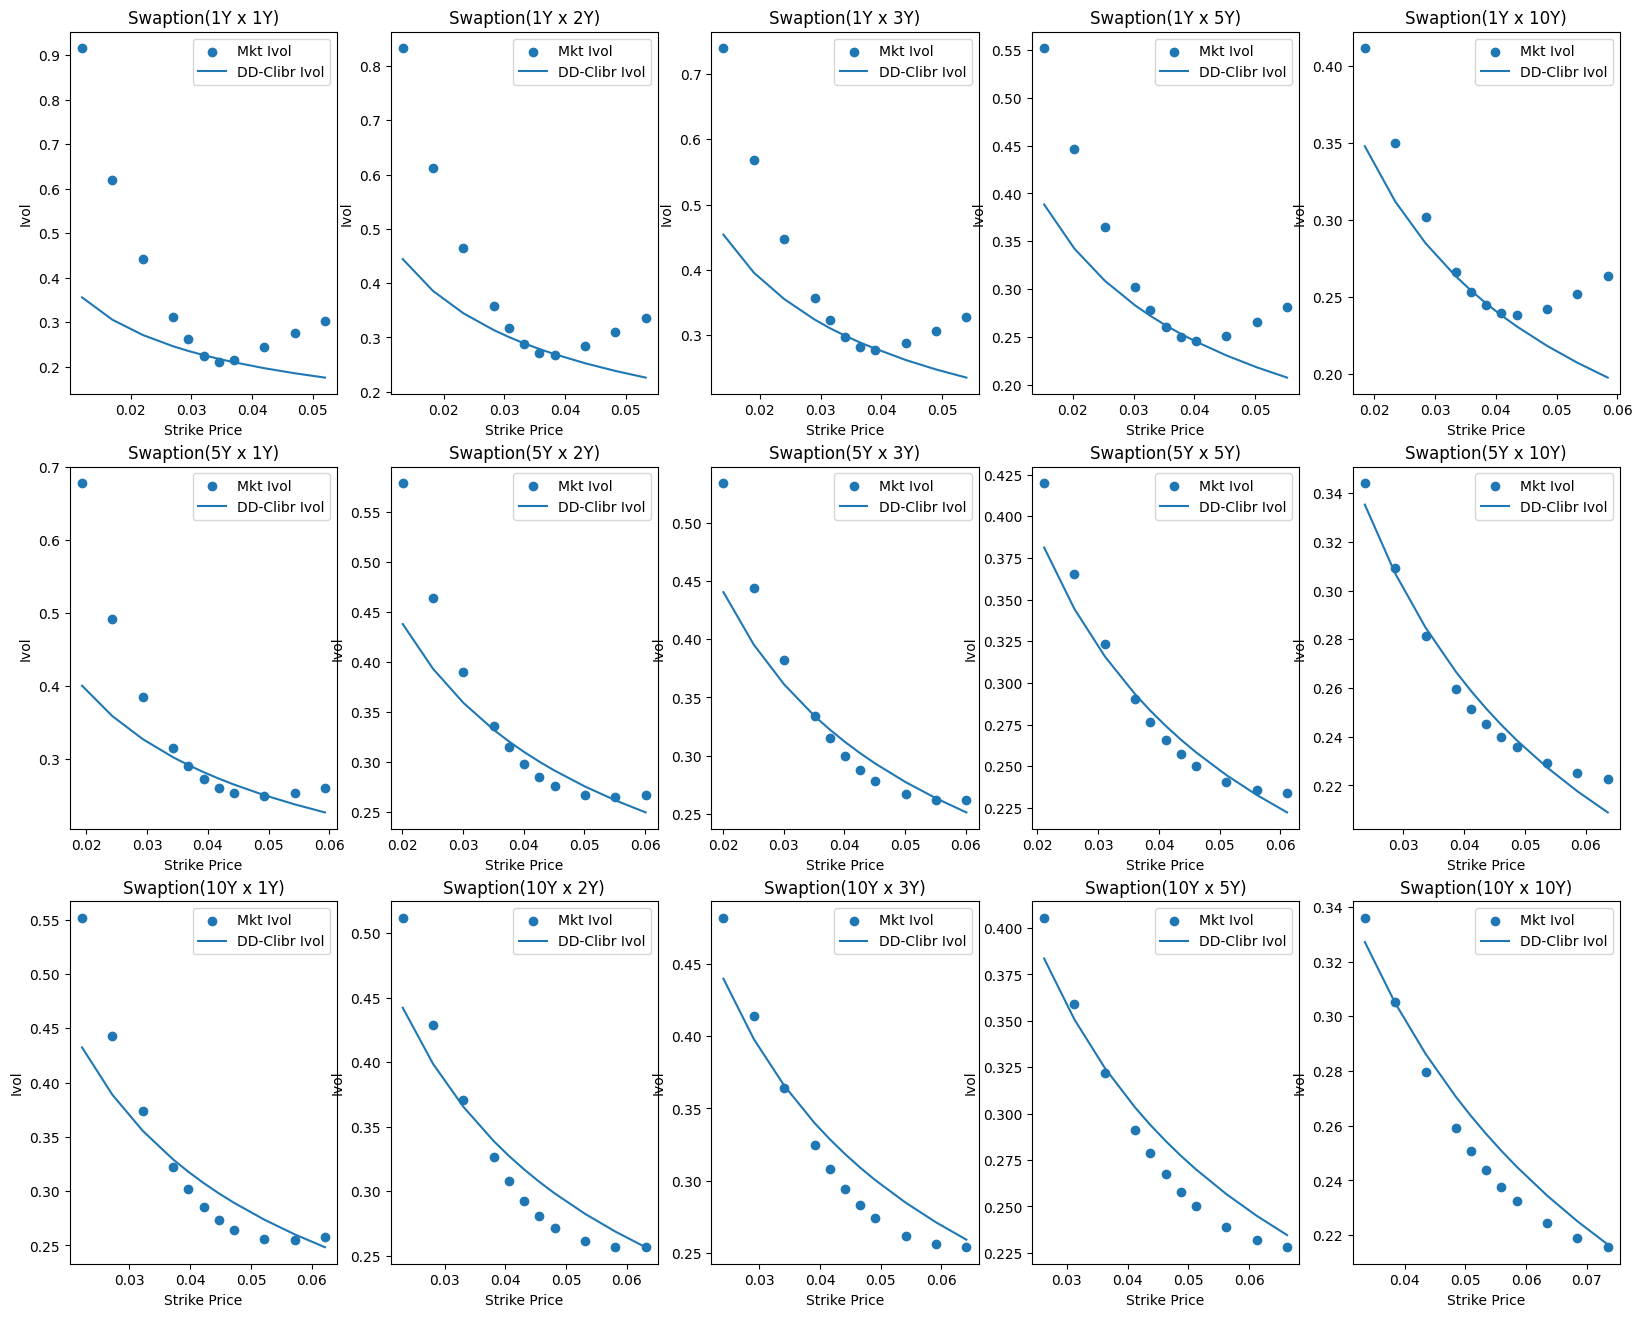

In [259]:
plt.figure(figsize=(20,16))
for i in range(len(fsr)):
    plt.subplot(3,5,i+1)
    S = fsr.iloc[i].iloc[2]
    strikes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] + S
    plt.scatter(strikes, fsr.iloc[i][4:15], label = 'Mkt Ivol')
    plt.plot(strikes, cal_dd_vol(fsr.iloc[i]), label = 'DD-Clibr Ivol')
    plt.legend()
    plt.ylabel('Ivol')
    plt.xlabel('Strike Price')
    plt.title('Swaption('+ str(int(fsr.iloc[i].iloc[0])) + 'Y x ' + str(int(fsr.iloc[i].iloc[1])) + 'Y)')